In [21]:
# Setting working Directory
cd("/Users/victoralexandrino/Google Drive/PhD Insper/Thesis/Paper 1 - Sovereign Default Holdings/Quant/Learning Julia")

pwd()

# Clear workspace

#clearconsole()

"/Users/victoralexandrino/Google Drive/PhD Insper/Thesis/Paper 1 - Sovereign Default Holdings/Quant/Learning Julia"

In [22]:
using Random, Distributions

#Initialization

function tauchen(ρ, σ, Ny, P)
    #Create equally spaced pts to fill into Z
    σ_z = sqrt((σ^2)/(1-ρ^2))
    Step = 10*σ_z/(Ny-1)
    Z = -5*σ_z:Step:5*σ_z

    #Fill in entries of 1~ny, ny*(ny-1)~ny^2
    for z in 1:Ny
        P[z,1] = cdf(Normal(), (Z[1]-ρ*Z[z] + Step/2)/σ)
        P[z,Ny] = 1 - cdf(Normal(),(Z[Ny] - ρ*Z[z] - Step/2)/σ)
    end

    #Fill in the middle part
    for z in 1:Ny
        for iz in 2:(Ny-1)
            P[z,iz] = cdf(Normal(), (Z[iz]-ρ*Z[z]+Step/2)/σ) - cdf(Normal(), (Z[iz]-ρ*Z[z]-Step/2)/σ)
        end
    end
end

tauchen (generic function with 1 method)

In [52]:
# Parameters

Ny = 5                         # Number of grids for output process
Nb = 5                       # Number of grids for real bonds
Nbnom = 5                      # Number of grids for nominal bonds
Npix = 5                       # Number of grids for P_{-1}
maxIter = 500                   # Number os max iterations
maxInd = Ny * Nb * Nbnom * Npix        # Total number of states
rstar = 0.0145                  # risk free interest rate
lbd = 0                         # Lower bound for real debt grid
ubd = 0.6                       # Upper bound for real debt grid
lbdnom = 0                      # Lower bound for nominal debt grid
ubdnom = 0.6                    # Upper bound for nominal debt grid
lbpix = 1                       # Lower bound for P_{-1}
ubpix = 1.6                     # Upper bound for P_{-1}
rrisk = 0.5                     # Risk aversion
β = 0.77                        # SDF
τ = 0.11                        # Output cost
θ = 0.5                         # Probability of re-entry
tol = 1e-5                      # Tolerance for VFI
ϕ = rrisk                       # Risk aversion
δ = 0.8                         # Check convergence parameter
ρ = 0.71                        # Output autocorrelation
σ = 0.025                       # Output volatility

ω = 0.5                         # Share of tradables
yn = 3.3                        # Non-tradable output
cn = yn                         # Non-tradable consumption
γ = 1.3                         # Inflation cost
g = 0.11                        # Government expenditure
μ = 0                         # Ownership share
target = 1                   # Inflation target


# Initial values

B = zeros(Nb)               # Initial real bond guess
Bnom = zeros(Nbnom)         # Initial nominal bond guess
Pix = zeros(Npix)           # Initial P_{-1} guess
Y = zeros(Ny)               # Initial output guess
σ_z = sqrt((σ^2)/(1-ρ^2))   # Initial volatility of output
Step = 10*σ_z/(Ny-1)        # Initial gap output discretization
Y = -5*σ_z:Step:5*σ_z       # Initial output = equals output grid

B_policy = zeros(Ny,Nb,Nbnom,Npix)
Bnom_policy = zeros(Ny,Nb,Nbnom,Npix)
Pix_policy = zeros(Ny,Nb,Nbnom,Npix)
c_policy = zeros(Ny,Nb,Nbnom,Npix)
infl_policy = zeros(Ny,Nb,Nbnom,Npix)

c_def_policy = zeros(Ny)


P = zeros(Ny,Ny)                                     # Initial transition matrix
V = fill(1/((1-β)*(1-rrisk)), Ny, Nb, Nbnom, Npix)    # Initial guess for V, equals to 1/((1-β)*(1-rrisk)) with a dimension of Ny x Nb
Price = fill(1/(1+rstar),Ny, Nb, Nbnom, Npix)        # Initial guess for bond price, with a dimension of Ny x Nb
Pricenom = fill(1/(1+rstar),Ny, Nb, Nbnom, Nb, Nbnom, Npix) # It depends on current bonds as well, since e_t/e_{t+1} is part of pricing equation
Vr = zeros(Ny, Nb, Nbnom, Npix)                      # Initial guess for value of repayment, with a dimention of Ny x Nb
Vd = zeros(Ny)                                      # Initial guess for value of default, dimension Ny
decision = ones(Ny,Nb,Nbnom,Npix)                    # Initial guess for prob of default, dimension Ny x Nb

U(x) = x^(1-ϕ) / (1-ϕ)                               # Utility function, x is consumption. Do not need to call function argument

L(m) = γ*(m-target)^2                                     # Loss inflation function

#Initialize Real Bond grid: Discretize bond
minB = lbd                              # Lower bound bond grid
maxB = ubd                              # Upper bound bond grid
step = (maxB-minB) / (Nb-1)             # Equalized space for bond grid
B = minB:step:maxB                      # Creating bond grid

# Initialize Nominal Bond grid: Discretize bond

minBnom = lbdnom
maxBnom = ubdnom
stepnom = (maxBnom-minBnom) / (Nbnom-1)
Bnom = minBnom:stepnom:maxBnom

# Initialize P_{-1}

minPix = lbpix
maxPix = ubpix
steppix = (maxPix-minPix) / (Npix-1)
Pix = minPix:steppix:maxPix

#Initialize Shock grid
tauchen(ρ, σ, Ny, P)                    # Call exogenous process. Result is P, a Ny x Ny matrix with probabilities

sumdef = 0                              # LHS of value of default

err = 2000                              # Initial error
tol = 1e-5                              # Initial tolerance
iter = 0                                # Initial tolerance

time_vd = 0                             # ?
time_vr = 0                             # ?
time_decide = 0                         # ?


0

In [53]:
# Starting VFI
#3
while (err > tol) & (iter < maxIter)
    V0 = deepcopy(V)                               # Using V as initial value
    Vd0 = deepcopy(Vd)                             # Using Vd as initial value
    Price0 = deepcopy(Price)                       # Using Price as initial value
    Pricenom0 = deepcopy(Pricenom)                 # Using Pricenom as initial value
    prob = zeros(Ny,Nb,Nbnom,Npix)                 # Initializing probability of default
    # display(V0)

#5 OUTSIDE LOOP: On state variables s={b*,b,P_{-1},y_t}
    for ib in 1:Nb                      # Initialize iteration on bonds
        for ibnom in 1:Nbnom
            for ipix in 1:Npix
                for iy = 1:Ny                   # Initialize iteration on output


    # Compute default and repayment
    #7

    # Value of default

            sumdef = U(exp((1-τ)*Y[iy])) - L(0)                                # LHS utility of default, with output cost
            for y in 1:Ny                                               # Here, he defines a new integer "y", which corresponds to next period y
                sumdef += (β* P[iy,y]* (θ* V0[y,1,1,1] + (1-θ)* Vd0[y]))    # Interating in output the RHS of value of default
            end
            Vd[iy] = sumdef                                             # Calling total value of default as sumdef

            # Policy functions

            c_def_policy[iy] = exp((1-τ)*Y[iy])


    # Compute value of repayment
    #8

            Max = -Inf                                                  # Calling max as -∞
            for b in 1:Nb                                               # Iterating on bonds
                for bnom in 1:Nbnom
                    for pix in 1:Npix

# If \omega = 1/2, we have a closed form solution:

                        if ω == 0.5

                            Atry = exp(Y[iy]) - g + (1-μ)*(Price0[iy,b,bnom,pix]*B[b] - B[ib]) + μ*(Pricenom0[iy,b,bnom,ib,ibnom,pix]*Bnom[bnom] - Bnom[ibnom])
                            Btry = (1/Pix[pix])*(1/ω)*((1/cn)^(1-ω))*μ*(Bnom[ibnom] - Pricenom0[iy,b,bnom,ib,ibnom,pix]*Bnom[bnom])
                            ct = ((-(Btry^2 + 4*Atry)^0.5 - Btry)^2)/4

                        #else

                            # Solve non-linear equation.

                            #ct = exp(Y[iy]) + Price0[iy,b,bnom,pix]*B[b] - B[ib] + (Pricenom0[iy,b,bnom,ib,ibnom,pix]*Bnom[bnom] - Bnom[ibnom])*(1/ω)*((1/yn)^(1 - ω))*(1/Pix[pix])*((ct/yn))^(1 - ω)

                        end

# Solve non-linear equation. You have a closed form solution


                #ct = exp(Y[iy]) + Price0[iy,b,bnom,pix]*B[b] - B[ib] + (Pricenom0[iy,b,bnom,ib,ibnom,pix]*Bnom[bnom] - Bnom[ibnom])*(1/ω)*((1/yn)^(1 - ω))*(1/Pix[pix])*((ct/yn))^(1 - ω)

                        if ct > 0
                    sumret = 0                                          # Utility in repayment
                            for y in 1:Ny                                       # Iterating on output
                        sumret += P[iy,y]*V0[y,b,bnom,pix]                       # Writing the total value of repayment
                            end
                    vr = U(ct) - L(Pix[pix]/Pix[ipix]) + β * sumret                              # Defining value of default
                    Max = max(Max, vr)                                  # Assuring that vr > ∞
                        end

                    end # for pix in 1:Npix
                end # for bnom in 1:Nbnom
            end # for b in 1:Nb

            Vr[iy,ib,ibnom,ipix] = Max                                             # Writing vale as the max utility after iteration

                    
            # Finding policy functions in repayment

            Vrmax,irmax = findmax(Vr)

            B_policy[iy,ib,ibnom,ipix] = B[irmax[2]]
            Bnom_policy[iy,ib,ibnom,ipix] = Bnom[irmax[3]]
            Pix_policy[iy,ib,ibnom,ipix] = Pix[irmax[4]]

            Atry = exp(Y[iy]) - g + (1-μ)*(Price0[iy,irmax[2],irmax[3],irmax[4]]*B[irmax[2]] - B[ib]) + μ*(Pricenom0[iy,irmax[2],irmax[3],ib,ibnom,irmax[4]]*Bnom[irmax[3]] - Bnom[ibnom])
            Btry = (1/Pix[irmax[4]])*(1/ω)*((1/cn)^(1-ω))*μ*(Bnom[ibnom] - Pricenom0[iy,irmax[2],irmax[3],ib,ibnom,irmax[4]]*Bnom[irmax[3]])
            c_policy[iy,ib,ibnom,ipix] = ((-(Btry^2 + 4*Atry)^0.5 - Btry)^2)/4

            infl_policy[iy,ib,ibnom,ipix] = Pix[irmax[4]]/Pix[ipix]



            #Choose repay or default
            if (Vd[iy] < Vr[iy,ib,ibnom,ipix])                                     # If value of default is lower...
                V[iy,ib,ibnom,ipix] = Vr[iy,ib,ibnom,ipix]                                    # It chooses to repay
                decision[iy,ib,ibnom,ipix] = 0                                     # DDefault decision equals zero
            else
                V[iy,ib,ibnom,ibpix] = Vd[iy]                                       # If not, it chooses to default
                decision[iy,ib,ibnom,ipix] = 1                                     # Default decision equals one
            end

            #calculate debt price

            for y in 1:Ny                                               # Iterating again in y, we calculate the debt price
                prob[iy,ib,ibnom,ipix] += P[iy,y] * decision[y,ib,ibnom,ipix]                 # Probability of default is also stochastic, so we should iterate prob() in iy and ib
            end

            # Real bond price

            Price[iy,ib,ibnom,ipix] = (1-prob[iy, ib, ibnom, ipix]) / (1+rstar)

            # Nominal bond price
            for b in 1:Nb
                for bnom in 1:Nbnom
                    for pix in 1:Npix
            
            Pricenom[iy,b,bnom,ib,ibnom,ipix] = ((1-prob[iy, ib, ibnom, ipix]) / (1+rstar)) * infl_policy[iy,ib,ibnom,ipix] * (c_policy[iy,ib,ibnom,ipix]/yn)^(ω - 1) 
                    
                            end # for pix in 1:Npix
                        end # for bnom in 1:Nbnom
            end # for b in 1:Nb             

                end # for iy = 1:Ny
            end # for ipix in 1:Npix
        end # for ibnom in 1:Nbnom
    end # for ib in 1:Nb


    err = maximum(abs.(V-V0))                                           # Convergence on continuation value
    PriceErr = maximum(abs.(Price-Price0))                              # Convergence on bond price
    PricenomErr = maximum(abs.(Pricenom-Pricenom0))
    VdErr = maximum(abs.(Vd-Vd0))                                       # Convergence on value of default
    Vd = δ * Vd + (1-δ) * Vd0                                           # Average value of default
    Price = δ * Price + (1-δ) * Price0                                  # Average bond price
    Pricenom = δ * Pricenom + (1 - δ) * Pricenom0
    V = δ * V + (1-δ) * V0                                              # Average continuation value

    iter = iter + 1                                                     # Iterations
    
#     println("Errors of round $iter: Value error: $err, real price error: $PriceErr, Vd error: $VdErr") # Print number of iterations and errors in value function, bond prices and value of default
    println("Errors of round $iter: Value error: $err, real price error: $PriceErr, nom price error: $PricenomErr, Vd error: $VdErr") # Print number of iterations and errors in value function, bond prices and value of default

end # while (err > tol) & (iter < maxIter)


println("Total Round ",iter)                                            # Print number of iterations after convergence

# Vd = Vd[:,:]                                                            # Saving value of default


Errors of round 1: Value error: 0.5889453697347413, real price error: 0.885150396436379, nom price error: 1.8250937606466995, Vd error: 4.2122134241003275
Errors of round 2: Value error: 0.8003495465167818, real price error: 0.7081203171491033, nom price error: 4.410953716558574, Vd error: 2.2917831383890976
Errors of round 3: Value error: 0.2230887697925681, real price error: 0.1416240634298206, nom price error: 0.9889404408875508, Vd error: 1.181790561649409
Errors of round 4: Value error: 0.09763764937235031, real price error: 0.028324812685964096, nom price error: 0.19778808817751026, Vd error: 0.5886729086262426
Errors of round 5: Value error: 0.043045488342402294, real price error: 0.00566496253719273, nom price error: 0.03955761763550214, Vd error: 0.28313520208217113
Errors of round 6: Value error: 0.03395709001265068, real price error: 0.0011329925074385905, nom price error: 0.00791152352710034, Vd error: 0.12960856977801427
Errors of round 7: Value error: 0.027424790344458216

In [55]:
# Print everything

# println("Vr: ====================")
# display(Vr)
# println("Vd: ==================")
# display(Vd)
# println("Decision: ==================")
# display(decision)
# println("Price: ==================")
display(Price)
println("Pricenom: ==================")
display(Pricenom)
# println("Consumption: ==============")
# display(c_policy)
# println("Inflation: =================")
# display(infl_policy)
# println("P_{t}: =============")
# display(Pix_policy)
# println("Real Bond: ===============")
# display(B_policy)
# println("Nominal bond: ================")
# display(Bnom_policy)      

10×10×10×10 Array{Float64, 4}:
[:, :, 1, 1] =
 0.985707  0.985707  0.985707  0.985707  …  0.985707  0.985707  0.985707
 0.985707  0.985707  0.985707  0.985707     0.985707  0.985707  0.985707
 0.985707  0.985707  0.985707  0.985707     0.985707  0.985707  0.985707
 0.985707  0.985707  0.985707  0.985707     0.985707  0.985707  0.985707
 0.985707  0.985707  0.985707  0.985707     0.985707  0.985707  0.985707
 0.985707  0.985707  0.985707  0.985707  …  0.985707  0.985707  0.985707
 0.985707  0.985707  0.985707  0.985707     0.985707  0.985707  0.985707
 0.985707  0.985707  0.985707  0.985707     0.985707  0.985707  0.985707
 0.985707  0.985707  0.985707  0.985707     0.985707  0.985707  0.985707
 0.985707  0.985707  0.985707  0.985707     0.985707  0.985707  0.985707

[:, :, 2, 1] =
 0.985707  0.985707  0.985707  0.985707  …  0.985707  0.985707  0.985707
 0.985707  0.985707  0.985707  0.985707     0.985707  0.985707  0.985707
 0.985707  0.985707  0.985707  0.985707     0.985707  0.985707

10×10×10×10×10×10 Array{Float64, 6}:
[:, :, 1, 1, 1, 1] =
 2.09958  2.09958  2.09958  2.09958  …  2.09958  2.09958  2.09958  2.09958
 2.05258  2.05258  2.05258  2.05258     2.05258  2.05258  2.05258  2.05258
 2.00689  2.00689  2.00689  2.00689     2.00689  2.00689  2.00689  2.00689
 1.96246  1.96246  1.96246  1.96246     1.96246  1.96246  1.96246  1.96246
 1.91923  1.91923  1.91923  1.91923     1.91923  1.91923  1.91923  1.91923
 1.87717  1.87717  1.87717  1.87717  …  1.87717  1.87717  1.87717  1.87717
 1.83622  1.83622  1.83622  1.83622     1.83622  1.83622  1.83622  1.83622
 1.79635  1.79635  1.79635  1.79635     1.79635  1.79635  1.79635  1.79635
 1.75751  1.75751  1.75751  1.75751     1.75751  1.75751  1.75751  1.75751
 1.71966  1.71966  1.71966  1.71966     1.71966  1.71966  1.71966  1.71966

[:, :, 2, 1, 1, 1] =
 2.09958  2.09958  2.09958  2.09958  …  2.09958  2.09958  2.09958  2.09958
 2.05258  2.05258  2.05258  2.05258     2.05258  2.05258  2.05258  2.05258
 2.00689  2.00689  2

Pricenom: ==================


In [49]:
# # Storing as CSV

# using Parsers
# using DataFrames
# using CSV

# dfPrice = DataFrame(Price)
# dfPricenom = DataFrame(Pricenom)
# dfVr = DataFrame(Vr)
# dfVd = DataFrame(Vd)
# dfDecision = DataFrame(decision)

# CSV.write("/Users/deng/Desktop/school/ECON8873/codes/Price.csv", dfPrice)
# CSV.write("/Users/deng/Desktop/school/ECON8873/codes/Vr.csv", dfVr)
# CSV.write("/Users/deng/Desktop/school/ECON8873/codes/Vd.csv", dfVd)
# CSV.write("/Users/deng/Desktop/school/ECON8873/codes/Decision.csv", dfDecision)


LoadError: ArgumentError: 'Array{Float64, 4}' iterates 'Float64' values, which doesn't satisfy the Tables.jl `AbstractRow` interface

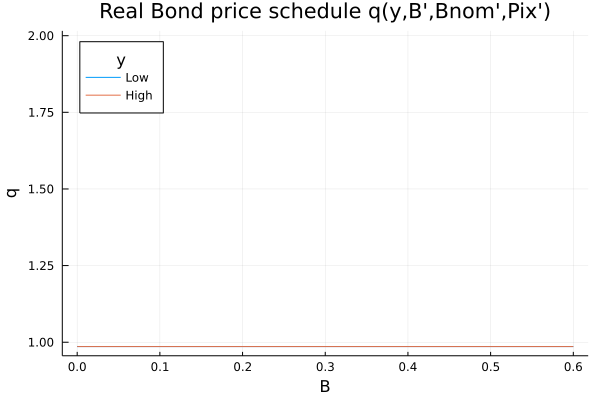

In [56]:
using DataFrames, Plots
gr(fmt=:png);

# Bond Price Schedule 

# 1) Real bond price

# Create a "Y High" and a "Y Low" values at 5% devs from the mean 
high = 1.5 * mean(Y)
low = 0.5 * mean(Y) 
iy_high,iy_low = map(x -> searchsortedfirst(Y,x), (high,low))

# Extract a suitable plot grid 
x = zeros(0)
Price_low = zeros(0)
Price_high = zeros(0)

for ib in 1:Nb
    for ibnom in 1:Nbnom 
        for ipix in 1:Npix 
            rbond = B[ib] 
            #nbond = Bnom[ibnom]
            # if 0 ≤ rbond ≤ 0.4
            push!(x,rbond)
            #push!(x,nbond)
            push!(Price_low,Price[iy_low,ib,ibnom,ipix])
            push!(Price_high,Price[iy_high,ib,ibnom,ipix])
             #end 
        end
    end
end  

plot(x,Price_low,label = "Low")
plot!(x,Price_high,label = "High")
plot!(title = "Real Bond price schedule q(y,B',Bnom',Pix')",
xlabel = "B", ylabel = "q", legend_title = "y", legend = :topleft)


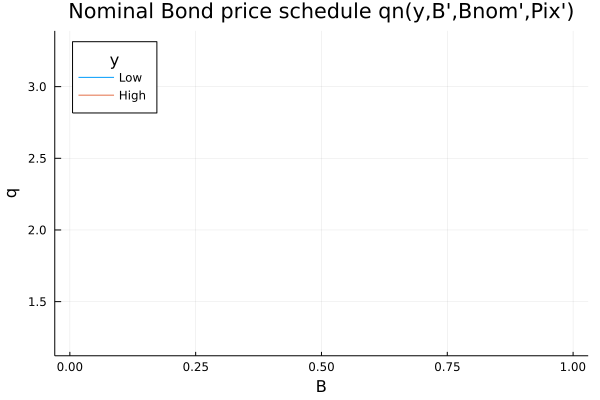

In [39]:
# 2) Nominal bond price 

# Create a "Y High" and a "Y Low" values at 5% devs from the mean 
high = 1.5 * mean(Y)
low = 0.5 * mean(Y) 
iy_high,iy_low = map(w -> searchsortedfirst(Y,w), (high,low))

# Extract a suitable plot grid 
w = zeros(0)
Pricenom_low = zeros(0)
Pricenom_high = zeros(0)

for ib in 1:Nb
    for ibnom in 1:Nbnom 
        for ipix in 1:Npix
            for b in 1:Nb
                for bnom in 1:Nbnom
                    for pix in 1:Npix
            #rbond = B[ib] 
            nbond = Bnom[ibnom]
             if 0 ≤ nbond ≤ 0.4
            #push!(x,bond)
            push!(x,nbond)
            push!(Pricenom_low,Pricenom[iy_low,b,bnom,ib,ibnom,ipix])
            push!(Pricenom_high,Pricenom[iy_high,b,bnom,ib,ibnom,ipix])
             end 
                    end 
                end 
            end 
        end
    end
end  

plot(w,Pricenom_low,label = "Low")
plot!(w,Pricenom_high,label = "High")
plot!(title = "Nominal Bond price schedule qn(y,B',Bnom',Pix')",
xlabel = "B", ylabel = "q", legend_title = "y", legend = :topleft)

In [40]:
# Value Functions

using DataFrames, Plots
gr(fmt=:png);

plot(B,Vr[iy_low,:,:,:], label = "Low")
plot!(B,Vr[iy_high,:,:,:], label = "High")
plot!(xlabel = "B", ylabel = "Vr(y,B,Bnom,Pix)", title = "Value Functions",
     legend_title="y", legend = :topleft)



LoadError: MethodError: no method matching expand_extrema!(::Plots.Axis, ::Array{Float64, 3})
[0mClosest candidates are:
[0m  expand_extrema!(::Plots.Axis, [91m::Nothing[39m) at /Users/victoralexandrino/.julia/packages/Plots/isZEW/src/axes.jl:387
[0m  expand_extrema!(::Plots.Axis, [91m::Bool[39m) at /Users/victoralexandrino/.julia/packages/Plots/isZEW/src/axes.jl:388
[0m  expand_extrema!(::Plots.Axis, [91m::Number[39m) at /Users/victoralexandrino/.julia/packages/Plots/isZEW/src/axes.jl:382
[0m  ...

In [44]:
# Heat map for default probability 

# Real bond

heatmap(B[1:end-1],
    Y[2:end],
    reshape(calmp.(vec(prob[1:end - 1, 1:end-1, 1:end-1, 1:end-1]), 0, 1), 250, 20)')
plot!(xlabel= "B", ylabel = "y", title = "Prob of default", legend = :topleft)

LoadError: UndefVarError: prob not defined